Environment A bins: 4
Environment B bins: 4
Total bins: 8

Transition matrix (rows sum to 1):
 [[0.28494832 0.09250917 0.09250917 0.03003333 0.125      0.125
  0.125      0.125     ]
 [0.09250917 0.28494832 0.03003333 0.09250917 0.125      0.125
  0.125      0.125     ]
 [0.09250917 0.03003333 0.28494832 0.09250917 0.125      0.125
  0.125      0.125     ]
 [0.03003333 0.09250917 0.09250917 0.28494832 0.125      0.125
  0.125      0.125     ]
 [0.125      0.125      0.125      0.125      0.28494832 0.09250917
  0.09250917 0.03003333]
 [0.125      0.125      0.125      0.125      0.09250917 0.28494832
  0.03003333 0.09250917]
 [0.125      0.125      0.125      0.125      0.09250917 0.03003333
  0.28494832 0.09250917]
 [0.125      0.125      0.125      0.125      0.03003333 0.09250917
  0.09250917 0.28494832]]


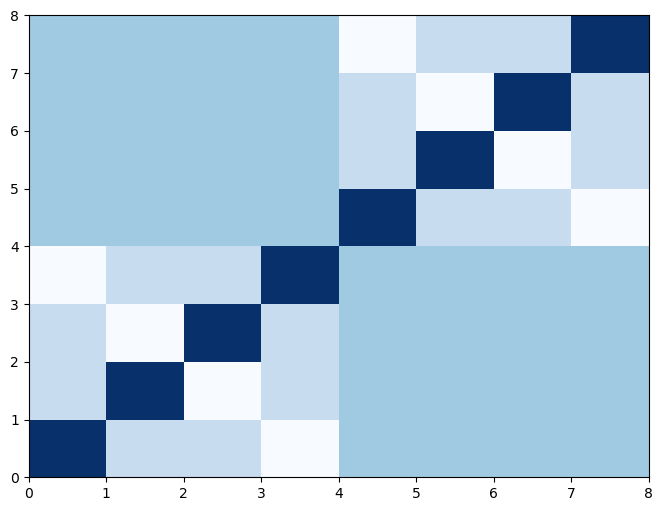

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from non_local_detector.environment import Environment
from non_local_detector.model.state_spec import StateSpec
from non_local_detector.transitions.continuous.kernels import (
    EuclideanRandomWalkKernel,
    UniformKernel,
)
from non_local_detector.transitions.continuous.orchestrators.block import BlockTransition
from non_local_detector.observations.base import ObservationModel

# 1. Create two simple 2D environments using sample clusters
#    - State A: points around (0, 0)
#    - State B: points around (5, 5)
cluster_A = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=float)
cluster_B = np.array([[5, 5], [5, 6], [6, 5], [6, 6]], dtype=float)

# Build environments with bin_size = 2.0 (so each cluster becomes a small grid)
env_A = Environment.from_samples(
    cluster_A, name="StateA", layout_kind="RegularGrid", bin_size=2.0
)
env_B = Environment.from_samples(
    cluster_B, name="StateB", layout_kind="RegularGrid", bin_size=2.0
)

# 2. Define StateSpec for each state. We use `obs_model=None` since we focus on transitions here.
spec_A = StateSpec(name="A", env=env_A, obs_model=ObservationModel)
spec_B = StateSpec(name="B", env=env_B, obs_model=ObservationModel)

# 3. Choose kernels:
#    - Within-state transitions use a small Gaussian random walk (mean=0 in 2D, var=1.0).
#    - Cross-state transitions (A->B and B->A) will default to uniform jumps, because we won't supply them explicitly.
gaussian_kernel_A = EuclideanRandomWalkKernel(mean=np.zeros(2), var=1.0)
gaussian_kernel_B = EuclideanRandomWalkKernel(mean=np.zeros(2), var=1.0)

uniform_A = UniformKernel()
uniform_B = UniformKernel()

# 4. Build a state_map for diag blocks (A->A and B->B). Off-diagonals will be filled uniformly by BlockTransition.
state_map = {
    ("A", "A"): gaussian_kernel_A,
    ("B", "B"): gaussian_kernel_B,
}
# state_map = {
#     ("A", "A"): uniform_A,
#     ("B", "B"): gaussian_kernel_B,
#     ("A", "B"): uniform_A,  # A to B transitions
#     ("B", "A"): uniform_B,  # B to A transitions
# }

# 5. Construct the BlockTransition
block_trans = BlockTransition(state_map=state_map, state_specs=[spec_A, spec_B])

# 6. Compute a single (time-invariant) transition matrix. No covariates needed for these kernels.
trans_matrix = block_trans.matrix(covariates={})

# 7. Print out the shapes and the transition matrix
print("Environment A bins:", env_A.n_bins)
print("Environment B bins:", env_B.n_bins)
print("Total bins:", block_trans.n_bins_total)
print("\nTransition matrix (rows sum to 1):\n", trans_matrix)

plt.figure(figsize=(8, 6))
plt.pcolormesh(trans_matrix, cmap="Blues")

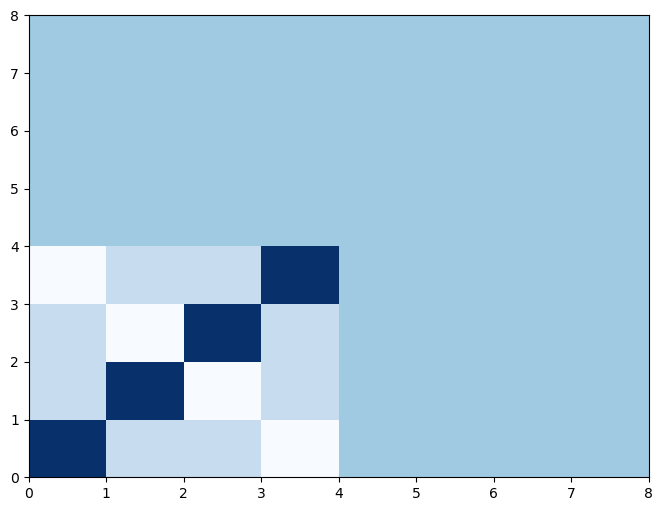

In [2]:
spec_cont = StateSpec(name="continuous", env=env_A, obs_model=ObservationModel)
spec_frag = StateSpec(name="fragmented", env=env_A, obs_model=ObservationModel)
gaussian_kernel = EuclideanRandomWalkKernel(mean=np.zeros(2), var=1.0)
uniform_kernel = UniformKernel()


state_map = {
    ("continuous", "continuous"): gaussian_kernel,
    ("fragmented", "fragmented"): uniform_kernel,
}

block_trans = BlockTransition(state_map=state_map, state_specs=[spec_cont, spec_frag])

# 6. Compute a single (time-invariant) transition matrix. No covariates needed for these kernels.
trans_matrix = block_trans.matrix(covariates={})

plt.figure(figsize=(8, 6))
plt.pcolormesh(trans_matrix.T, cmap="Blues")